# Standard Imports

In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score, f1_score, roc_curve 

# Custom Imports

In [2]:
custom_modules_path = os.path.abspath(r'F:\Capstone\DFCA')

# Add the path to sys.path
if custom_modules_path not in sys.path:
    sys.path.append(custom_modules_path)

from utils.datasets import SpectrogramDataset
from utils.augmentations import ZScoreNormalizeSpectrogram, AugmentSpectrogram
from utils.metrics_utils import calculate_pAUC, plot_confusion_matrix
from models.feature_extractor import STFTFrequencyAdaptiveFeatureExtractor
from models.heads import AnomalyScorer
from utils.metrics_utils import calculate_pAUC, plot_confusion_matrix

f:\CapStone\DFCA\capstone\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# STFT ResNet Classifier

In [3]:
class STFTResNetClassifier(nn.Module):
    def __init__(self, head):
        super().__init__()
        self.backbone = STFTFrequencyAdaptiveFeatureExtractor()
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.head = head
    
    def forward(self, x):
        features = self.backbone(x)
        pooled_features = self.pool(features)
        flattend_features = torch.flatten(pooled_features, 1)
        logits = self.head(flattend_features)
        return logits

# Device Configfuration's

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}" + (f" - {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else ""))

FEATURES_DIR = os.path.abspath(r'F:\CapStone\DFCA\data\features\-6_dB_valve_features')
CHECKPOINT_DIR = os.path.abspath(r'F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve')
print(f"Feature Directory: {FEATURES_DIR}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")


BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 5e-5
WEIGHT_DECAY = 1e-2
PATIENCE=5

print(f"Learning Rate: {LR} | Weight decay: {WEIGHT_DECAY}")

Using Device: cuda - NVIDIA GeForce MX450
Feature Directory: F:\CapStone\DFCA\data\features\-6_dB_valve_features
Checkpoints will be saved to: F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve
Learning Rate: 5e-05 | Weight decay: 0.01


# Evaluate and Training Loops

In [5]:
def _compute_primary_probs_and_loss_from_head(outputs, labels, criterion):
    """
    Computes probabilities, predictions, and loss for a binary classifier head.
    """
    logits = outputs.squeeze()
    probs = torch.sigmoid(logits)
    loss = criterion(logits, labels.float())
    preds = (probs > 0.5).long()
    return probs, preds, loss

def evaluate_model(model, data_loader, criterion, phase="Evaluation", device=device, threshold=0.5):
    model.eval()
    running_loss = 0.0
    all_labels, all_probs = [], []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc=phase):
            # 1. Load data to the specified device
            specs = batch['spectrogram'].to(device)
            labels = batch['label'].to(device).long()

            outputs = model(specs)

            probs, _, loss = _compute_primary_probs_and_loss_from_head(outputs, labels, criterion)

            running_loss += loss.item() * specs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    # --- Metrics Calculation ---
    avg_loss = running_loss / len(data_loader.dataset)
    
    # During validation, find the best F1-score and its threshold
    best_threshold = threshold
    if phase == "Validation":
        best_f1 = 0
        for thresh in np.arange(0.01, 1.0, 0.01):
            preds_at_thresh = (np.array(all_probs) > thresh).astype(int)
            f1_candidate = f1_score(all_labels, preds_at_thresh)
            if f1_candidate > best_f1:
                best_f1 = f1_candidate
                best_threshold = thresh
        print(f"Optimal Threshold found: {best_threshold:.2f} (Best F1-score: {best_f1:.4f})")

    # Use the best threshold for final predictions
    all_preds = (np.array(all_probs) > best_threshold).astype(int)
    
    # Calculate all metrics
    auc_score = roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else float('nan')
    acc_score = accuracy_score(all_labels, all_preds)
    bacc_score = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"{phase} -> Loss: {avg_loss:.4f} | AUC: {auc_score:.4f} | ACC: {acc_score:.4f} | BACC: {bacc_score:.4f} | F1: {f1:.4f}")
    print(f"Prediction Distribution: {dict(Counter(all_preds))}")

    return avg_loss, auc_score, acc_score, bacc_score, f1, all_labels, all_probs, best_threshold

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, model_save_path, device=device, save_plots=True, patience=5):
    best_val_auc = -np.inf
    best_val_loss = np.inf
    best_val_bacc = -np.inf
    best_threshold = 0.5
    patience_counter = 0

    train_losses, val_losses = [],[]
    train_accs, val_accs = [], []
    train_baccs, val_baccs = [], []
    train_aucs, val_aucs = [], []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        all_labels, all_probs, all_preds = [], [], []

        for batch in tqdm(train_loader, desc="Train"):
            specs = batch['spectrogram'].to(device)
            labels = batch['label'].to(device).long()

            optimizer.zero_grad()

            logits = model(specs)

            probs, preds, loss = _compute_primary_probs_and_loss_from_head(logits, labels, criterion)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * specs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            all_preds.extend(preds.detach().cpu().numpy())

        # --- End of Epoch: Calculate Training Metrics ---
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(all_labels, all_probs)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_bacc = balanced_accuracy_score(all_labels, all_preds)

        train_losses.append(epoch_loss)
        train_aucs.append(epoch_auc)
        train_accs.append(epoch_acc)
        train_baccs.append(epoch_bacc)
        
        print(f"Train -> Loss: {epoch_loss:.4f} | AUC: {epoch_auc:.4f} | ACC: {epoch_acc:.4f} | BACC: {epoch_bacc:.4f}")

        # --- Validation Step ---
        val_loss, val_auc, val_acc, val_bacc, _, _, _, current_optimal_threshold = evaluate_model(
            model, val_loader, criterion, phase="Validation", device=device, threshold=best_threshold # type: ignore
        )

        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_accs.append(val_acc)
        val_baccs.append(val_bacc)

        if scheduler:
            scheduler.step()

        if val_bacc > best_val_bacc:
            best_val_bacc = val_bacc
            patience_counter = 0
            bacc_path = model_save_path.replace(".pth", "_best_bacc.pth")
            torch.save(model.state_dict(), bacc_path)
            print(f"Saved Best-BACC model to {bacc_path} (val_bacc improved to {best_val_bacc:.4f}")
        else:
            patience_counter += 1
            print(f"Val BACC {val_bacc:.4f} did not improve from {best_val_bacc:.4f}. Patience: {patience_counter}/{patience}")
        
        # Save by best loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            loss_path = model_save_path.replace(".pth", "_best_loss.pth")
            torch.save(model.state_dict(), loss_path)
            print(f"Saved Best-Loss model to {loss_path} (val_loss improved to {best_val_loss:.4f})")

        # Save by best AUC
        if not np.isnan(val_auc) and val_auc > best_val_auc:
            best_val_auc = val_auc
            best_threshold = current_optimal_threshold
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved Best-AUC model to {model_save_path} (val_auc improved to {best_val_auc:.4f})")
        else:
            print(f"Val AUC {val_auc:.4f} did not improve from best {best_val_auc:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Plotting training history
    if save_plots:
        epochs = range(1, len(train_losses)+ 1)
        plt.figure(figsize=(18, 5))
        
        plt.subplot(1, 4, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Val Loss')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 2)
        plt.plot(epochs, train_aucs, label='Train AUC')
        plt.plot(epochs, val_aucs, label='Val AUC')
        plt.title('AUC')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 4, 3)
        plt.plot(epochs, train_accs, label='Train Accuracy')
        plt.plot(epochs, val_accs, label='Val Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 4, 4)
        plt.plot(epochs, train_baccs, label='Train BACC')
        plt.plot(epochs, val_baccs, label='Val BACC')
        plt.title('Balanced Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(os.path.dirname(model_save_path), "training_summary.png"))
        plt.show()
        plt.close()
        
    return best_threshold

# Main

Loading datasets for STFT spectrograms...
Total samples loaded: 4170
Split Sizes => Train: 2919, Val: 625, Test: 626
Label Distribution (Train): Counter({0: 2584, 1: 335})
Label Distribution (Validation): Counter({0: 553, 1: 72})
Label Distribution (Test): Counter({0: 554, 1: 72})
Data split => Train: 2919, Validation: 625, Test: 626
Label Distribution (Train): Counter({0: 2584, 1: 335})

Using BCEWithLogitsLoss with pos_weight: 7.71

Starting model training...

Epoch 1/50


Train: 100%|██████████| 91/91 [00:40<00:00,  2.27it/s]


Train -> Loss: 1.2538 | AUC: 0.5058 | ACC: 0.5076 | BACC: 0.4991


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.20it/s]


Optimal Threshold found: 0.48 (Best F1-score: 0.2412)
Validation -> Loss: 1.2107 | AUC: 0.5909 | ACC: 0.5872 | BACC: 0.5795 | F1: 0.2412
Prediction Distribution: {np.int64(1): 268, np.int64(0): 357}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model_best_bacc.pth (val_bacc improved to 0.5795
Saved Best-Loss model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model_best_loss.pth (val_loss improved to 1.2107)
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model.pth (val_auc improved to 0.5909)

Epoch 2/50


Train: 100%|██████████| 91/91 [00:38<00:00,  2.37it/s]


Train -> Loss: 1.1474 | AUC: 0.6666 | ACC: 0.6240 | BACC: 0.6274


Validation: 100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Optimal Threshold found: 0.16 (Best F1-score: 0.2727)
Validation -> Loss: 1.6606 | AUC: 0.6433 | ACC: 0.6160 | BACC: 0.6199 | F1: 0.2727
Prediction Distribution: {np.int64(0): 367, np.int64(1): 258}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model_best_bacc.pth (val_bacc improved to 0.6199
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model.pth (val_auc improved to 0.6433)

Epoch 3/50


Train: 100%|██████████| 91/91 [00:42<00:00,  2.15it/s]


Train -> Loss: 0.8483 | AUC: 0.8546 | ACC: 0.7335 | BACC: 0.7637


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.13it/s]


Optimal Threshold found: 0.84 (Best F1-score: 0.3055)
Validation -> Loss: 1.4847 | AUC: 0.6671 | ACC: 0.6944 | BACC: 0.6461 | F1: 0.3055
Prediction Distribution: {np.int64(0): 422, np.int64(1): 203}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model_best_bacc.pth (val_bacc improved to 0.6461
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model.pth (val_auc improved to 0.6671)

Epoch 4/50


Train: 100%|██████████| 91/91 [00:49<00:00,  1.84it/s]


Train -> Loss: 0.3482 | AUC: 0.9824 | ACC: 0.9183 | BACC: 0.9304


Validation: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


Optimal Threshold found: 0.26 (Best F1-score: 0.3319)
Validation -> Loss: 1.7549 | AUC: 0.7082 | ACC: 0.7552 | BACC: 0.6563 | F1: 0.3319
Prediction Distribution: {np.int64(0): 468, np.int64(1): 157}
Saved Best-BACC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model_best_bacc.pth (val_bacc improved to 0.6563
Saved Best-AUC model to F:\Capstone\DFCA\checkpoints\STFT_ResNet_Noval_valve\best_model.pth (val_auc improved to 0.7082)

Epoch 5/50


Train: 100%|██████████| 91/91 [00:52<00:00,  1.72it/s]


Train -> Loss: 0.1852 | AUC: 0.9943 | ACC: 0.9657 | BACC: 0.9663


Validation: 100%|██████████| 20/20 [00:03<00:00,  5.58it/s]


Optimal Threshold found: 0.02 (Best F1-score: 0.3110)
Validation -> Loss: 3.1955 | AUC: 0.6945 | ACC: 0.6880 | BACC: 0.6546 | F1: 0.3110
Prediction Distribution: {np.int64(1): 211, np.int64(0): 414}
Val BACC 0.6546 did not improve from 0.6563. Patience: 1/5
Val AUC 0.6945 did not improve from best 0.7082

Epoch 6/50


Train: 100%|██████████| 91/91 [00:50<00:00,  1.80it/s]


Train -> Loss: 0.0761 | AUC: 0.9993 | ACC: 0.9870 | BACC: 0.9900


Validation: 100%|██████████| 20/20 [00:03<00:00,  6.26it/s]


Optimal Threshold found: 0.01 (Best F1-score: 0.2423)
Validation -> Loss: 3.5234 | AUC: 0.6067 | ACC: 0.5296 | BACC: 0.5832 | F1: 0.2423
Prediction Distribution: {np.int64(1): 316, np.int64(0): 309}
Val BACC 0.5832 did not improve from 0.6563. Patience: 2/5
Val AUC 0.6067 did not improve from best 0.7082

Epoch 7/50


Train: 100%|██████████| 91/91 [00:58<00:00,  1.55it/s]


Train -> Loss: 0.1031 | AUC: 0.9977 | ACC: 0.9791 | BACC: 0.9790


Validation: 100%|██████████| 20/20 [00:02<00:00,  6.67it/s]


Optimal Threshold found: 0.51 (Best F1-score: 0.2785)
Validation -> Loss: 2.1714 | AUC: 0.6356 | ACC: 0.7264 | BACC: 0.6098 | F1: 0.2785
Prediction Distribution: {np.int64(1): 165, np.int64(0): 460}
Val BACC 0.6098 did not improve from 0.6563. Patience: 3/5
Val AUC 0.6356 did not improve from best 0.7082

Epoch 8/50


Train: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]


Train -> Loss: 0.0701 | AUC: 0.9990 | ACC: 0.9883 | BACC: 0.9895


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


Optimal Threshold found: 0.03 (Best F1-score: 0.3046)
Validation -> Loss: 3.4058 | AUC: 0.6924 | ACC: 0.7808 | BACC: 0.6224 | F1: 0.3046
Prediction Distribution: {np.int64(0): 500, np.int64(1): 125}
Val BACC 0.6224 did not improve from 0.6563. Patience: 4/5
Val AUC 0.6924 did not improve from best 0.7082

Epoch 9/50


Train: 100%|██████████| 91/91 [01:08<00:00,  1.33it/s]


Train -> Loss: 0.0773 | AUC: 0.9985 | ACC: 0.9849 | BACC: 0.9850


Validation: 100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


Optimal Threshold found: 0.07 (Best F1-score: 0.2417)
Validation -> Loss: 3.2753 | AUC: 0.6340 | ACC: 0.7088 | BACC: 0.5757 | F1: 0.2417
Prediction Distribution: {np.int64(1): 168, np.int64(0): 457}
Val BACC 0.5757 did not improve from 0.6563. Patience: 5/5
Val AUC 0.6340 did not improve from best 0.7082
Early stopping triggered after 9 epochs


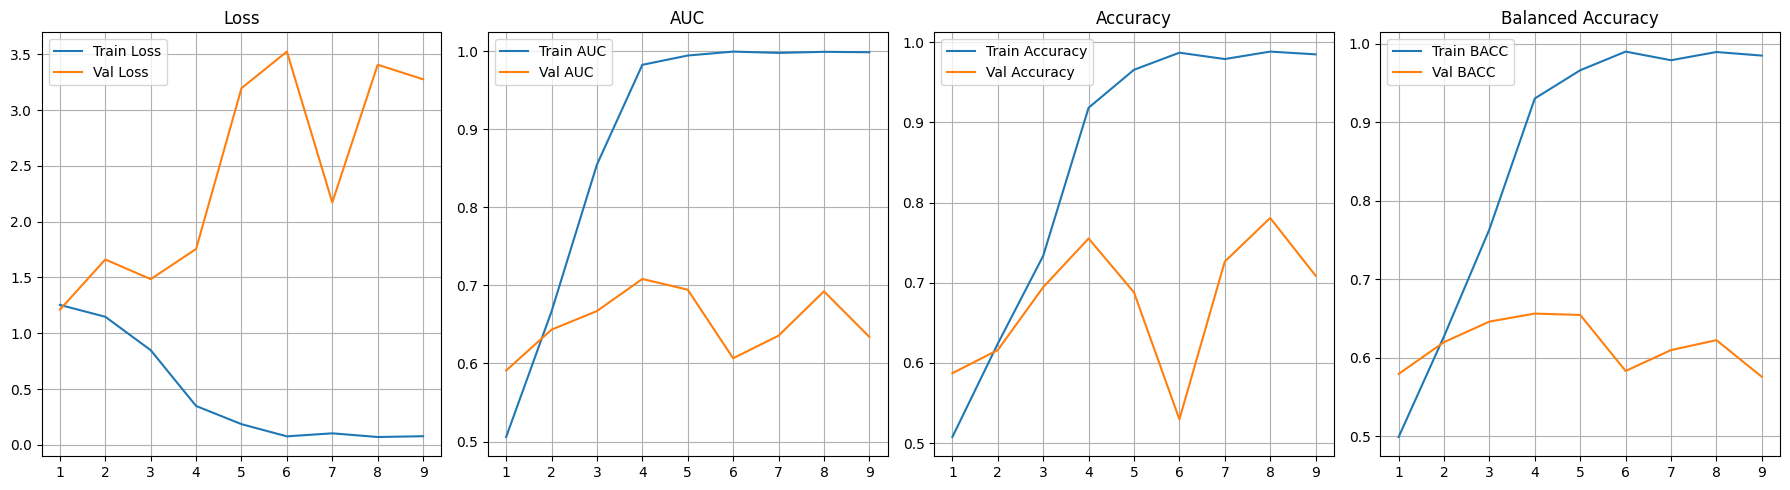


--- Final Test Evaluation ---
Evaluating test set with optimal threshold: 0.26


Test: 100%|██████████| 20/20 [00:03<00:00,  5.21it/s]


Test -> Loss: 1.9080 | AUC: 0.6859 | ACC: 0.7476 | BACC: 0.6218 | F1: 0.2946
Prediction Distribution: {np.int64(1): 152, np.int64(0): 474}

Final Test Metrics (Threshold = 0.26):
  -> Accuracy (ACC)         : 0.7476
  -> Balanced Accuracy (BACC): 0.6218
  -> AUC                    : 0.6859
  -> pAUC (FPR<=0.2)        : 0.2179
  -> F1-Score               : 0.2946


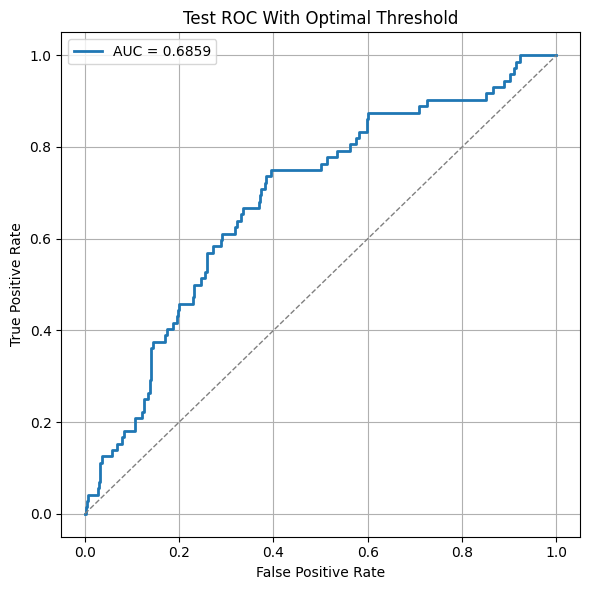

TP: 33 | TN: 435 | FP: 119 | FN: 39 | Precision: 0.2171 | Recall: 0.4583 | Specificity: 0.7852


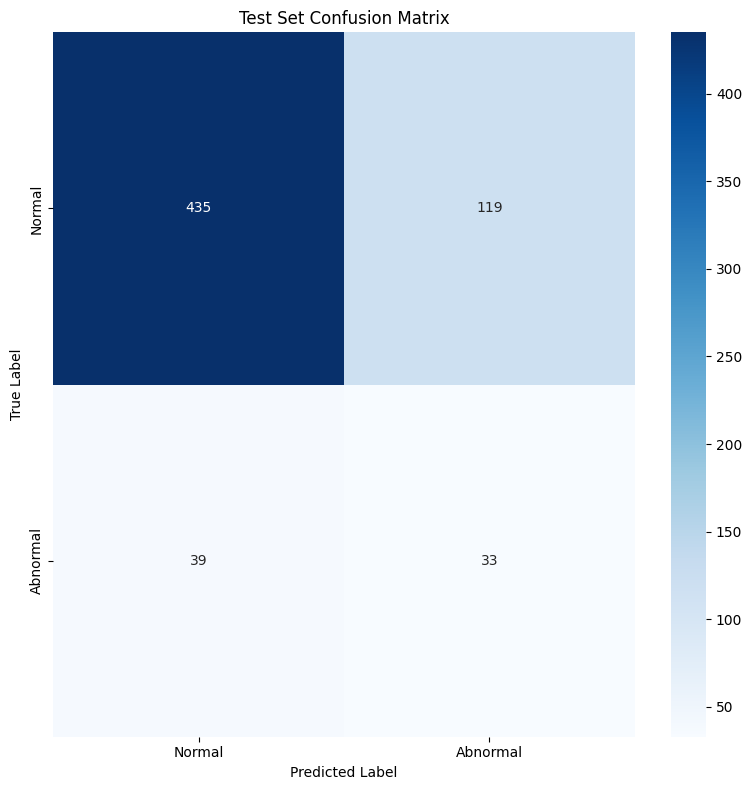

In [6]:
def main():
    # --- Configuration ---
    SEED = 42
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # --- Data Transformations ---
    train_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
        AugmentSpectrogram(time_mask_param=2, freq_mask_param=2) 
    ])
    val_test_transform = transforms.Compose([
        ZScoreNormalizeSpectrogram(),
    ])
    # --- Dataset Loading ---
    print("Loading datasets for STFT spectrograms...")
    # This assumes the SpectrogramDataset class from the previous answer is defined
    normal_dataset = SpectrogramDataset(data_dir=FEATURES_DIR, category='normal', spec_type='stft', transform=train_transform)
    abnormal_dataset = SpectrogramDataset(data_dir=FEATURES_DIR, category='abnormal', spec_type='stft', transform=train_transform)
    
    full_dataset = ConcatDataset([normal_dataset, abnormal_dataset])
    all_labels = [sample['label'] for sample in full_dataset] # type: ignore
    print(f"Total samples loaded: {len(full_dataset)}")

    # --- Stratified Data Splitting ---
    indices = list(range(len(full_dataset)))
    # Splitting indices: 70% train, 15% validation, 15% test
    train_idx, temp_idx, _, _ = train_test_split(indices, all_labels, test_size=0.3, stratify=all_labels, random_state=SEED)
    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx, _, _ = train_test_split(temp_idx, temp_labels, test_size=0.5, stratify=temp_labels, random_state=SEED)

    # Create dataset subsets with appropriate transforms
    full_dataset_no_aug = ConcatDataset([
        SpectrogramDataset(data_dir=FEATURES_DIR, category='normal', spec_type='stft', transform=val_test_transform),
        SpectrogramDataset(data_dir=FEATURES_DIR, category='abnormal', spec_type='stft', transform=val_test_transform)
    ])

    train_set = Subset(full_dataset, train_idx) # Uses augmentations
    val_set = Subset(full_dataset_no_aug, val_idx) # No augmentations
    test_set = Subset(full_dataset_no_aug, test_idx) # No augmentations

    print(f"Split Sizes => Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")
    print(f"Label Distribution (Validation): {Counter([all_labels[i] for i in val_idx])}")
    print(f"Label Distribution (Test): {Counter([all_labels[i] for i in test_idx])}")

    # --- Data Loaders ---
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Data split => Train: {len(train_set)}, Validation: {len(val_set)}, Test: {len(test_set)}")
    print(f"Label Distribution (Train): {Counter([all_labels[i] for i in train_idx])}")

    # --- Model, Criterion, and Optimizer Setup ---
    head = AnomalyScorer(in_dim=512, dropout=0.4, mode='classifier-1')
    model = STFTResNetClassifier(head=head).to(device)

    # Use weighted Binary Cross-Entropy loss for imbalanced data
    pos_count = sum(all_labels); neg_count = len(all_labels) - pos_count
    pos_weight = torch.tensor([neg_count / (pos_count + 1e-8)], dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(f"\nUsing BCEWithLogitsLoss with pos_weight: {pos_weight.item():.2f}")

    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

    model_path = os.path.join(CHECKPOINT_DIR, "best_model.pth")
    os.makedirs(os.path.dirname(model_path), exist_ok=True)

    # --- Training ---
    print("\nStarting model training...")
    best_threshold = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=NUM_EPOCHS,
        model_save_path=model_path,
        device=device,
        save_plots=True,
        patience=PATIENCE
    )
    
    # --- Final Test Evaluation ---
    print("\n--- Final Test Evaluation ---")
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Evaluate using the best threshold found during validation
    print(f"Evaluating test set with optimal threshold: {best_threshold:.2f}")
    
    # The simplified evaluate_model now returns the f1 score directly
    _, test_auc, test_acc, test_bacc, test_f1, all_labels_test, all_probs_test, _ = evaluate_model(
        model=model, data_loader=test_loader, criterion=criterion, phase="Test", device=device, threshold=best_threshold
    )
    
    # We must set the threshold for the test evaluation predictions.
    # The new evaluate_model does not take threshold as an argument, so we apply it manually for the final report.
    all_preds_test = (np.array(all_probs_test) > best_threshold).astype(int)
    final_acc = accuracy_score(all_labels_test, all_preds_test)
    final_bacc = balanced_accuracy_score(all_labels_test, all_preds_test)
    final_f1 = f1_score(all_labels_test, all_preds_test)
    final_pauc = calculate_pAUC(labels=all_labels_test, preds=all_probs_test, max_fpr=0.2)

    print(f"\nFinal Test Metrics (Threshold = {best_threshold:.2f}):")
    print(f"  -> Accuracy (ACC)         : {final_acc:.4f}")
    print(f"  -> Balanced Accuracy (BACC): {final_bacc:.4f}")
    print(f"  -> AUC                    : {test_auc:.4f}")
    print(f"  -> pAUC (FPR<=0.2)        : {final_pauc:.4f}")
    print(f"  -> F1-Score               : {final_f1:.4f}")

    # --- Plotting ---
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true=all_labels_test, y_score=all_probs_test)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {test_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC With Optimal Threshold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIR, "roc_test_optimal.png"))
    plt.show()
    plt.close()

    class_labels = ["Normal", "Abnormal"]
    plot_confusion_matrix(y_true=all_labels_test, y_pred=all_preds_test, labels=class_labels, save_path=CHECKPOINT_DIR, title="Test Set Confusion Matrix")


if __name__ == "__main__":
    main()